#  실험은 여기서 했습니다.

In [173]:
"""Example running MemN2N on a single bAbI task.
Download tasks from facebook.ai/babi """
from __future__ import absolute_import
from __future__ import print_function

from data_utils import load_task, vectorize_data
from sklearn import metrics
from sklearn.model_selection import train_test_split
from memn2n import MemN2N
from itertools import chain
from six.moves import range, reduce

import tensorflow as tf
import tensorboard as tb
import numpy as np

In [2]:
tf.app.flags.DEFINE_string('f', '', 'kernel')
tf.flags.DEFINE_float("learning_rate", 0.01, "Learning rate for SGD.")
tf.flags.DEFINE_float("anneal_rate", 25, "Number of epochs between halving the learnign rate.")
tf.flags.DEFINE_float("anneal_stop_epoch", 100, "Epoch number to end annealed lr schedule.")
tf.flags.DEFINE_float("max_grad_norm", 40.0, "Clip gradients to this norm.")
tf.flags.DEFINE_integer("evaluation_interval", 10, "Evaluate and print results every x epochs")
tf.flags.DEFINE_integer("batch_size", 32, "Batch size for training.")
tf.flags.DEFINE_integer("hops", 3, "Number of hops in the Memory Network.")
tf.flags.DEFINE_integer("epochs", 100, "Number of epochs to train for.")
tf.flags.DEFINE_integer("embedding_size", 20, "Embedding size for embedding matrices.")
tf.flags.DEFINE_integer("memory_size",5, "Maximum size of memory.")
tf.flags.DEFINE_integer("task_id",3, "bAbI task id, 1 <= id <= 20")
tf.flags.DEFINE_integer("random_state", None, "Random state.")
tf.flags.DEFINE_string("data_dir", "memn2n/data/tasks_1-20_v1-2/en/", "Directory containing bAbI tasks")
FLAGS = tf.flags.FLAGS

print("Started Task:", FLAGS.task_id)

Started Task: 3


In [253]:
train, test = load_task(FLAGS.data_dir, FLAGS.task_id)
data = train + test
temp = data

c:\program files\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [211]:
sentence_size = max(map(len, chain.from_iterable(s for s, _, _ in data)))
max_story_size = max(map(len, (s for s, _, _ in data)))


In [177]:
for s, q, a in data:
    ss =[]
    for i, sentence in enumerate(s,1):
        ls = max(0, sentence_size - len(sentence))
        

1

# Word2Vec

In [155]:
#extracts query and supporting sentences
def extract_seeds():
    seed_sentence =[]
    for i in range(len(train)):
        for j in range(len(train[i][0])):
            seed_sentence.append(train[i][0][j])
        seed_sentence.append(train[0][1])
    return seed_sentence

In [157]:
seeds = extract_seeds()
seeds

[['mary', 'moved', 'to', 'the', 'bathroom'],
 ['sandra', 'journeyed', 'to', 'the', 'bedroom'],
 ['mary', 'got', 'the', 'football', 'there'],
 ['john', 'went', 'back', 'to', 'the', 'bedroom'],
 ['mary', 'journeyed', 'to', 'the', 'office'],
 ['john', 'journeyed', 'to', 'the', 'office'],
 ['john', 'took', 'the', 'milk'],
 ['daniel', 'went', 'back', 'to', 'the', 'kitchen'],
 ['john', 'moved', 'to', 'the', 'bedroom'],
 ['daniel', 'went', 'back', 'to', 'the', 'hallway'],
 ['daniel', 'took', 'the', 'apple'],
 ['john', 'left', 'the', 'milk', 'there'],
 ['john', 'travelled', 'to', 'the', 'kitchen'],
 ['sandra', 'went', 'back', 'to', 'the', 'bathroom'],
 ['daniel', 'journeyed', 'to', 'the', 'bathroom'],
 ['john', 'journeyed', 'to', 'the', 'bathroom'],
 ['mary', 'journeyed', 'to', 'the', 'bathroom'],
 ['sandra', 'went', 'back', 'to', 'the', 'garden'],
 ['sandra', 'went', 'to', 'the', 'office'],
 ['daniel', 'went', 'to', 'the', 'garden'],
 ['sandra', 'went', 'back', 'to', 'the', 'hallway'],
 ['dan

In [167]:
#making word2vec models, note for hyperparameters, sg means 'skip gram', if 0, CBOW models
model = gensim.models.Word2Vec(seeds, min_count=1, window=5, size = 40, sg=1)

### 왜 사이즈 80보다 작게 해야 하는가

전체 단어의 개수 8X... 
(ex 구글 뉴스에서는 60만이다. 0/1 임베딩이라면 60만이어야 하는데.)
(성능이 좋게 나와서 300....) 근거는 크게 없다...

단어들끼리 많은 뜻을 포함하지 않음.(babi에서)
사람이 이야기하는것도 추상화할수록 
(고양이/개)
(한승현/김일택)....
임베딩//추상화... 

In [220]:
vocab = np.array(list(model.wv.vocab))
X = np.array(model[vocab])
vec_idx = list(zip(vocab,X))

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [194]:
sess = tf.InteractiveSession()

In [226]:
vec_idx[0][1]

array([-0.49135277,  0.04565951, -0.56161994, -0.4531402 , -0.5926927 ,
        0.00086545, -0.09092297,  0.43231598, -0.03884997, -0.14996888,
        0.17249605, -0.2933959 ,  0.8144721 ,  0.75404257, -0.07795498,
        0.04671605, -0.2664085 ,  0.20956336,  0.40557778, -0.04828088,
       -0.56210995,  0.4272186 , -0.29899487, -0.07289588, -0.30378905,
        0.07366199,  0.26040646, -0.00758162, -0.2500866 ,  0.42947167,
       -0.32810014,  0.31824553, -0.09316144, -0.10679617,  0.43320638,
       -0.14901307, -0.6774177 ,  0.35585526,  0.47001082,  0.51441014],
      dtype=float32)

In [256]:
temp[0][0][0]

['mary', 'moved', 'to', 'the', 'bathroom']

In [252]:
for i in temp:
    for 
        a = vec_idx[i][1]


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([-0.48074037,  0.02858865, -0.567339  , -0.47377697, -0.5176318 ,
        0.03367941, -0.06994258,  0.38302788, -0.05443157, -0.19250111,
        0.21835832, -0.3282635 ,  0.83076024,  0.7973252 , -0.07763459,
       -0.00678066, -0.2598199 ,  0.18821678,  0.44201088, -0.06907975,
       -0.56529343,  0.41746524, -0.2670388 , -0.03751758, -0.36260366,
        0.07414223,  0.23261279, -0.02383137, -0.2531647 ,  0.49617094,
       -0.36729646,  0.32067412, -0.09686123, -0.05949904,  0.42430723,
       -0.15037408, -0.67668134,  0.35584578,  0.5259776 ,  0.5154773 ],
      dtype=float32)

In [ ]:
for i in range(data):
    ss=[]
    if i in vec_idx
        current=vec_idx.i. value
    else
        current=<UNKNOW>
    ss.append(current)

In [204]:
print(data[0][0])

[['mary', 'moved', 'to', 'the', 'bathroom'], ['sandra', 'journeyed', 'to', 'the', 'bedroom'], ['mary', 'got', 'the', 'football', 'there'], ['john', 'went', 'back', 'to', 'the', 'bedroom'], ['mary', 'journeyed', 'to', 'the', 'office'], ['john', 'journeyed', 'to', 'the', 'office'], ['john', 'took', 'the', 'milk'], ['daniel', 'went', 'back', 'to', 'the', 'kitchen'], ['john', 'moved', 'to', 'the', 'bedroom'], ['daniel', 'went', 'back', 'to', 'the', 'hallway'], ['daniel', 'took', 'the', 'apple'], ['john', 'left', 'the', 'milk', 'there'], ['john', 'travelled', 'to', 'the', 'kitchen'], ['sandra', 'went', 'back', 'to', 'the', 'bathroom'], ['daniel', 'journeyed', 'to', 'the', 'bathroom'], ['john', 'journeyed', 'to', 'the', 'bathroom'], ['mary', 'journeyed', 'to', 'the', 'bathroom'], ['sandra', 'went', 'back', 'to', 'the', 'garden'], ['sandra', 'went', 'to', 'the', 'office'], ['daniel', 'went', 'to', 'the', 'garden'], ['sandra', 'went', 'back', 'to', 'the', 'hallway'], ['daniel', 'journeyed', 't

In [202]:
print(vec_idx)

{'mary': array([-0.49135277,  0.04565951, -0.56161994, -0.4531402 , -0.5926927 ,
        0.00086545, -0.09092297,  0.43231598, -0.03884997, -0.14996888,
        0.17249605, -0.2933959 ,  0.8144721 ,  0.75404257, -0.07795498,
        0.04671605, -0.2664085 ,  0.20956336,  0.40557778, -0.04828088,
       -0.56210995,  0.4272186 , -0.29899487, -0.07289588, -0.30378905,
        0.07366199,  0.26040646, -0.00758162, -0.2500866 ,  0.42947167,
       -0.32810014,  0.31824553, -0.09316144, -0.10679617,  0.43320638,
       -0.14901307, -0.6774177 ,  0.35585526,  0.47001082,  0.51441014],
      dtype=float32), 'moved': array([ 0.11837979, -0.21893014,  0.28873155, -0.790366  ,  0.45490855,
       -0.43798438, -0.9150037 ,  0.22468446,  0.2084201 ,  0.23963334,
       -0.09883949, -0.99050707,  0.30314478, -0.29070893,  0.7042016 ,
        0.33457696, -0.5307271 ,  0.40428546, -0.34077126, -0.3095621 ,
        0.07968123, -0.22235054, -0.50898343, -0.5768554 , -0.15896717,
        0.12745897, -0.

# T-SNE로 표현한 대략적인 인접도(Supporting Sentence ONLY)

In [164]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


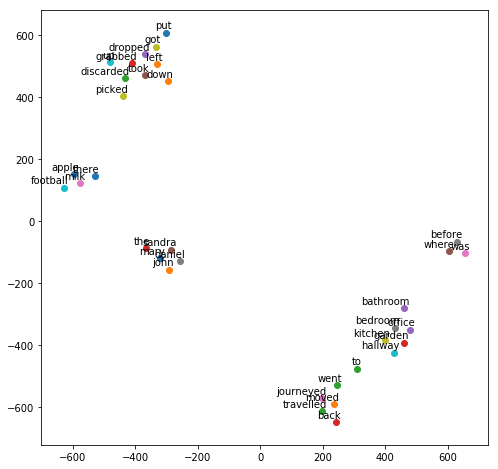

In [165]:
tsne_plot(model)

# 여기까지 했는데요, 